In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

In [2]:
mutable struct AutoregressiveFilterbank <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function AutoregressiveFilterbank(y, x, θ, w; id=ForneyLab.generateId(AutoregressiveFilterbank))
        
        # ensure that the input arguments are random variables
        @ensureVariables(y, x, θ, w) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:y] = self.interfaces[1] = ForneyLab.associate!(Interface(self), y)
        self.i[:x] = self.interfaces[2] = ForneyLab.associate!(Interface(self), x)
        self.i[:θ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), θ)
        self.i[:w] = self.interfaces[4] = ForneyLab.associate!(Interface(self), w)
        
        # return object
        return self
    end
end

In [3]:
# add shortcut for calling the filter bank
slug(::Type{AutoregressiveFilterbank}) = "ARFB"

slug (generic function with 1 method)

In [4]:
function ruleVariationalARFBOutNPPP(marg_y::Nothing, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    mθ = ForneyLab.unsafeMean(marg_θ)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)
                        
    # calculate new parameters
    my = mθ .* mx
    wy = mw

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wy*my, w=wy)

end

ruleVariationalARFBOutNPPP (generic function with 1 method)

In [5]:
function ruleVariationalARFBIn1PNPP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::Nothing, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})
    
    # caluclate required means
    my = ForneyLab.unsafeMean(marg_y)
    mθ = ForneyLab.unsafeMean(marg_θ)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    wx = (vθ' + mθ*mθ') .* mw
    mx = inv(wx) * Diagonal(mθ) * mw * my

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wx*mx, w=wx)

end

ruleVariationalARFBIn1PNPP (generic function with 1 method)

In [6]:
function ruleVariationalARFBIn2PPNP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::Nothing, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vx = ForneyLab.unsafeCov(marg_x)

    # calculate new parameters
    wθ = (vx' + mx*mx') .* mw
    mθ = inv(wθ) * Diagonal(mx) * mw * my

    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wθ*mθ, w=wθ)

end

ruleVariationalARFBIn2PPNP (generic function with 1 method)

In [7]:
function ruleVariationalARFBIn3PPPN(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::Nothing)

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mθ = ForneyLab.unsafeMean(marg_θ)

    # calculate required variances
    vy = ForneyLab.unsafeCov(marg_y)
    vx = ForneyLab.unsafeCov(marg_x)
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    v = vy + my*my' - (mθ .* mx)*my' - my*(mx .* mθ)' + Diagonal(mθ)*vx*Diagonal(mθ) + Diagonal(mx)*vθ*Diagonal(mx)  + (mθ .* mx)*(mθ .* mx)' + vθ.*vx
    nu = size(v,1) + 2 

    # create variational message
    Message(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=inv(v), nu=nu)

end

ruleVariationalARFBIn3PPPN (generic function with 1 method)

In [8]:
@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBOutNPPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBIn1PNPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, Nothing, ProbabilityDistribution),
                      :name          => VariationalARFBIn2PPNP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{ForneyLab.Wishart},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution, Nothing),
                      :name          => VariationalARFBIn3PPPN)


In [9]:
function generateARFB(nr_γ, bufsize)
    
    model = quote
        
        fg = FactorGraph()
        
        @RV [id=:smin] smin ~ GaussianMeanVariance(placeholder(:μ_smin, dims=(2*$nr_γ,)), placeholder(:Σ_smin, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:θ] θ ~ GaussianMeanVariance(placeholder(:μ_θ, dims=(2*$nr_γ,)), placeholder(:Σ_θ, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:w] w ~ ForneyLab.Wishart(placeholder(:v_w, dims=(2*$nr_γ,2*$nr_γ)), placeholder(:nu_w))
        @RV [id=:s] s ~ AutoregressiveFilterbank(smin, θ, w)
        @RV [id=:x] x = placeholder(:c, dims=($bufsize,2*$nr_γ)) * s
        @RV [id=:y] y ~ GaussianMeanVariance(x, placeholder(:Σ_x, dims=($bufsize,$bufsize)))
        placeholder(y, :y, dims=($bufsize,))
        
        q = PosteriorFactorization(smin, s, θ, w, ids=[:smin, :s, :θ, :w])

    end
    
end

generateARFB (generic function with 1 method)

In [10]:
# load speech data
xi, fs = wavread("../data/leaves.wav", format="native")
fs = Int(fs)
xi = convert(Array{Float64,1}, xi[1*fs:4*fs])

# pre-process signals
yi = preprocess(xi, fs) 

N = length(yi)
t = collect(1:N)/8000
fs = 8000

audioplayers(yi, fs=8000);

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQDK80G94H7ZvTg4mb01RXC9sSnKPDokebzHbAO8i29PPZ65hz2IW5m66eC1PKIiz70AB4m9pjJTvWuxwLttCTk9v1WhPTkpdT1FlK08dg8pvTRoMz0dWJw9d3qiPQgQWT1tSL48SvssvQHwPLwAwSO84dBPuyay5jwyE/Q7rJOdPQEsIztWYby8uJ24vX9mZ72fhvG9Z3Xevc+Jwr2dvMO90uiiPG59G7yuFP88CJ26PRInHD3WdGg9fNxXPVUxtTx6f8c9qWwLPXSDajxAtXO7+VitvKNcFztdQ+E7C0mCuprfMLxr7Xo9lyoxOyQ7RzxiKZq78yxLu09hlTtiTCA9C4c6PZbEXr3E8A+8g02rO6jigzxxdpY7ha5bPdDeB7zYFQK8b6Ukvbu4pby2fL68DXdjPTT5ujwDk8A96LIwvUOqOjsU4G+9Rtzrvf3eYr18xBC7VxuWvUFFaL1ksAC8/ISOPVRICj08jV08KUULvWnktL2de5m9UhS/vcS5zrw4emi9VARuu0dbqr1ylzK80tPfuwECOz3NP6A9eIOUvBukNz1gezI9lGHfPJHD0byEzvS6NQ4nveeqbj2Yq9M8aTpYPH9kNj60yM28CVaPPfcZo7xK48i8dVtEPIzCgT0kBKE9dZxePCMBTT2XD1o9vFqFvNyO6ruzH4+8GJqdvaSMvrx80Y69sSjSvHqV9zxO7hc9GbMSPP3E6bx7PUO9kpoPvEcIHT18Gk09nqnKvA9koLwg/8a9sT/yvAoMJL2abC6984M5vZPGKr11VoC9ChvIvYL6jL1q7QK9timPPSEOmT2Tb6o97QT0PWIIjT1RxAw8CF7Su0S0LbyPGzU9XwsBuyxM1z0iSZm9iUJMvZkdbLsaUAY9XmujPV3RjzwWGwW9Qpg6PQpg/DwcHGU9OjMFPU2ABLtrz7u8WvudvBB3ULoLHd+6Qoh6vaAqB7zsuYA72V5+PcH6tbwyJXS8zS+CvVgStLxgkZ09il+APZXMuT3i5qs9Fqwsu2DtYT0HY2S84P92vWMRa70BI3e7zRQ/vb4F6bzY5zq+AiQIvgMc+Lz//gu94XZVvQusTLzTs4c8RKBPvFj5Tb1xfSk9pMc+PUh9j7zBDYy9tyOMvaV4tr0PXGC9VP8xPb65kT2AbJM8yxXfvPkd2zyV0FW7+a3IOutz8z3EhG49CJqhPdAhCj7yjBw+d/GYPcRRDDu1JA28SSFyO0s+mz3HLa89WIs8vfIN0byFory9LeXavb/AQjxD/bG9j2hZvBRV0jwzqze9BJyWPeAu/j3bGL89pcgVPvZEzz0DMZm8mk+dPTgV+TxXas28llh+u4uQLL57vQC+8M2cvVpVvr15pWe9fBfEvTwc6bxVC4M82ANAPC3Phr3AzKC9RedKPKaTtL2sKsc9Oa0dPttBoDx2mzy9LLK/vSgX47w6iHo8Y6KxvDewir2VdZo8hgJ8PN6U4ruRyXu7XQyevEVCmzybpeg80Wcau8FVQ70M4Og9b1p9PD4f/zzfqYG9pKvvvEoQoTwVhPo7LmIYPPpAez0OO687yZcVPOfq5jxC/xe9rkgmPT9Jvz1rMI887bGbvJrCzzwI8Jw9pQmNPWz9m730Uh69RmEvvfXRfb0bIGe89yYDvZfZaz2SQW08CKUOvUy2ND3tNtY9pWe7PR5WaL1OLbq9dQ/3vAmbtr1uYY294iLevAq1KT12C5e9D3n0vCbYtb1HCZu9KaeUvN75Nj3jQaU8gisEvW+D3Dk7RxC92vOZvesZEz2ZfOo9r6QRPgwV1z263KA90vuqPfoeeT1NSxU9j7BIPWVeWT2kMsk8xMsgPblcTjzcmYY8DVutN7rhAr2NV4m8o6qEvAT5QrsLluk6Aq4QPcpbkLnR4Ui9QdwSvXPIsr28vCy+71lHvgGkkL2w1hs8ttnHPBrYqDuK/0S81IOIvVOzRDyX3V49DKQGPfHDqD2B0Zm76xc7vbq0yTzTn2s8TfMTvePVB732VRS8UTlnvDlq9jsMTPK86FelvYR2vL3RN1O9KtSAvaNZr7zHrCw9Te/YPFm2qT1ELG49OCPGvC4Nkb0RuRO6kAw1vY+80Du8V+E9S28HPtRGIT2A6og9Nl1CPBHMWz2KQbk8ryidPQEb+T2DUYA9lpWxPdrh4zyx3nQ9bIHcvEVuKLvGmyg6cHW6vAR6H70WDtS9ZZWTveohgb0Qots8zBf4PQ4Zlz3T44E9sugoPSGeEz06Ffa8QrzMvJdI6TuQqMy9YbULvg/XIr4HJtK9zYGJvdpzgLwzJ5S7WhWmvU6o3bi/qC89V7pGPEAUwDzgWSY9VJQ4PVjF+Tyjmr87P1+DPQGNWz2JRPQ8wvMbPV6zGD2/EUQ9SWDevCzlM72wIr69NSSUvUC0e72v4wK+pADxvcBsr72rEcm7gjv/PN/k5TwqvR09jSSePDGJhz1TyqA9+rS9PZ9LPT18PpA9SxuvPMhr0r0wWli9BYvEPFOxdDz+Wui7I1gLPfMIE7y0+y08XoQ6vdr+cL3fBrE8skqKPYH7gzwmJAQ9Ai4mPVcyY71lA7A734IKvP8rlDyMZUY9UdxJvZsLxDzC5H29OnyVvZYZorvPvoM9Wr6tPbpfOrxMBzw9D8h1PUqrIb2gG8U7sxtZPTUIXbycf6a8RReOPDqig7wimY6991iSO67pn7wshQa9uJ0Eut30Tr2XLS28lqspPSLJnL19yu68NyFuPTf0JT5C+L0970GcvVJJp73e6hi7fkNBPb3yCb3MhGo8F1k7vSrpg72xl8a8K5yRvf4A6b3iqG29LUD3vDSIxj3qtfQ9yTZnPQW7uz3w+Pw9xG53Pc0aDz1SfmY8xe5zvQh2zr12qhq+L8oRvpTHSr2bGj09Qj4APtV9vj1G8tY7/VDOOwBBgLtL1Qq9cjdOPRbowzzjBNW79RTsPMjWLL0Vei69Ci2PvY/THT3WQHw96CT3PBBfZL0r3IK9zPmZPJKHoTxxJ0U9tqmPPYOfcL3WBc296vGxvFBhrbwEQm+7RWfGPEKXPj38f0E9rnkDPlhcqj3lJ3s9hLoXPcxj5zt/Vk87kY1ovAD8jr12GM+8rnbSvXG6AL4Fpo+95twqvNrRXr2eMni9dRvNvTxULr57Eay91ll5vcsKOT1TdHA9mQRRu1jHVD2+raQ9XIqiPP9XpD1E4pw9bI0gPUrXNT3AEYk9jrpaPJhGlDy1L+49EujOPE0MvTxFSiI8PhdHvN/L5z2AYw88A/+PvN4rFz3LjfA8LjmFum7jDT1R2KI7eufXurakP72CJYm9XR9tvDYkWb0rkR69uYtgvIw4cL3eI4y9m6Cuur3SLjygmsY9wlQoPQq9VLyQXMg7wh5+vPbSmr3z7ay86R5APQDH6jxh96M9yIUYuwapVr3bmwi9kYLcvYAEv725KIi9CIJ6vRTOrjx2nca8QvAFvX1KOT0xPKI8yfShvV0Sq7x24dg8tVUMPUnjez3CqOM9hQymPWC18Txl4bg9LkJ6PLCYvrwwJUe8K39rvdB4G72c+lK9BxpmPD8VrzzJt4Y7C88EPTzgLTuPSSw94ywAverwkbwnr5G608oFvXEL3Lz6Pr+9Ye8BvdZ7dD20jfC4BaswvYJlaL0hqpi99v1kvT5YKD2AdiC85ltuPFh+ETwf1CY9wpt8PAraoj3P0Ig96GSJPOQmszzF95i9ITr/O/EFSbx7lYS9ivvYvBgMA72xdcc9yw4GPkz9eD2wFAA+pSe6PQaHrz3jkqg8OalUPU1gijy4np09nt15PcT4ar1HlTu8168zvlXuiTxBB6Y9VPhKveyJ9rwpIxG+IdTTvUDLMb2Ince8g30ovoOpBb3JNJy9fGOrPawNXz1y2

In [37]:
f = collect(fs/20:fs/20:fs/2)
bufsize = 2*length(f)

# create fg
eval(generateARFB(length(f), bufsize))
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7449830237888137590 -->
 7449830237888137590 
 
 × 
 multiplication_1 
 
<!-- 10380882145854370986 -->
 10380882145854370986 
 
 placeholder_c 
 
<!-- 7449830237888137590--10380882145854370986 -->
 7449830237888137590--10380882145854370986 
 
 c 
 1 out 
 3 a 
 
<!-- 4540132507882261424 -->
 4540132507882261424 
 
 AutoregressiveFilterbank 
 autoregressivefilterbank_1 
 
<!-- 7449830237888137590--4540132507882261424 -->
 7449830237888137590--4540132507882261424 
 
 s 
 1 y 
 2 in1 
 
<!-- 10061610279969184686 -->
 10061610279969184686 
 
 placeholder_v_w 
 
<!-- 7245623470776006860 -->
 7245623470776006860 
 
 placeholder_Σ_smin 
 
<!-- 9816820332524982904 -->
 9816820332524982904 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 9816820332524982904--7449830237888137590 -->
 9816820332524982904--7449830237888137590 
 
 x 
 1 out 
 2 m 
 
<!-- 16999772694508295378 -->
 16999772694508295378 
 
 placeholder_Σ_x 
 
<!-- 9816820332524982904--16999772694508295378 -->
 9816820332524982904--16999772694508295378 
 
 Σ_x 
 1 out 
 3 v 
 
<!-- 6125156802267765185 -->
 6125156802267765185 
 
 placeholder_μ_smin 
 
<!-- 10821262331377415686 -->
 10821262331377415686 
 
 placeholder_nu_w 
 
<!-- 16533364347895254663 -->
 16533364347895254663 
 
 W 
 wishart_1 
 
<!-- 4540132507882261424--16533364347895254663 -->
 4540132507882261424--16533364347895254663 
 
 w 
 1 out 
 4 w 
 
<!-- 15399483770665748122 -->
 15399483770665748122 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 4540132507882261424--15399483770665748122 -->
 4540132507882261424--15399483770665748122 
 
 θ 
 1 out 
 3 θ 
 
<!-- 13355219114380972523 -->
 13355219114380972523 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 4540132507882261424--13355219114380972523 -->
 4540132507882261424--13355219114380972523 
 
 smin 
 1 out 
 2 x 
 
<!-- 16533364347895254663--10061610279969184686 -->
 16533364347895254663--10061610279969184686 
 
 v_w 
 1 out 
 2 v 
 
<!-- 16533364347895254663--10821262331377415686 -->
 16533364347895254663--10821262331377415686 
 
 nu_w 
 1 out 
 3 nu 
 
<!-- 15876006874787430956 -->
 15876006874787430956 
 
 placeholder_Σ_θ 
 
<!-- 15399483770665748122--15876006874787430956 -->
 15399483770665748122--15876006874787430956 
 
 Σ_θ 
 1 out 
 3 v 
 
<!-- 16264255359280215449 -->
 16264255359280215449 
 
 placeholder_μ_θ 
 
<!-- 15399483770665748122--16264255359280215449 -->
 15399483770665748122--16264255359280215449 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 13355219114380972523--7245623470776006860 -->
 13355219114380972523--7245623470776006860 
 
 Σ_smin 
 1 out 
 3 v 
 
<!-- 13355219114380972523--6125156802267765185 -->
 13355219114380972523--6125156802267765185 
 
 μ_smin 
 1 out 
 2 m 
 
<!-- 3300273374190687972 -->
 3300273374190687972 
 
 placeholder_y 
 
<!-- 3300273374190687972--9816820332524982904 -->
 3300273374190687972--9816820332524982904 
 
 y 
 1 out 
 1 out

In [12]:
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepw!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBWishartOut(nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:v_w]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:nu_w]))
messages[2] = ruleVariationalARFBIn3PPPN(marginals[:s], marginals[:smin], marginals[:θ], nothing)

marginals[:w] = messages[1].dist * messages[2].dist

return marginals

end

function steps!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalARFBOutNPPP(nothing, marginals[:smin], marginals[:θ], marginals[:w])
messages[2] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(MatrixVariate, PointMass, m=data[:c]))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_x]))
messages[4] = ruleSPMultiplication

In [24]:
yifft = FFTovertime(yi, bufsize, bufsize-1, rectangularwindow; pad=0)
yifftr = real.(yifft)
ρ = repeat([cor(yifftr[2:end,k], yifftr[1:end-1,k]) for k = 2:length(f)+1],inner=2)
ρw = repeat([1/abs.(cov(yifftr[2:end,k], yifftr[1:end-1,k])) for k = 2:length(f)+1],inner=2)

20-element Array{Float64,1}:
   4.564931173052715
   4.564931173052715
   9.424566846647789
   9.424566846647789
  18.04655643512165 
  18.04655643512165 
  39.749695755812326
  39.749695755812326
 334.331106892265   
 334.331106892265   
  59.17706170836644 
  59.17706170836644 
  27.49294146007492 
  27.49294146007492 
  20.960972380848823
  20.960972380848823
  20.414498098586353
  20.414498098586353
  13.75311708016972 
  13.75311708016972 

In [25]:
μ_θ_mem = Array{Float64,2}(undef, N, 2*length(f))
Σ_θ_mem = Array{Float64,2}(undef, N, 2*length(f))
μ_x_mem = Array{Float64,1}(undef, N)
Σ_x_mem = Array{Float64,1}(undef, N)

# priors
μ_smin = zeros(2*length(f))
Σ_smin = 0.01*Ic(2*length(f))
μ_θ = ρ #ones(2*length(f))
Σ_θ = 1e-2*Ic(2*length(f))
v_w = diagm(ρw)/(2*length(f) + 2)
nu_w = 2*length(f) + 2
Σ_x = 1e-3*Ic(bufsize)

p = Progress(N-bufsize)
    marginals = Dict()

for n = bufsize:N
    
    next!(p)
    
    # fill marginals dictionary
    marginals[:smin] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_smin, v=Σ_smin)
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ, v=Σ_θ)
    marginals[:w] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=v_w, nu=nu_w)
    
    # fill data dictionary
    data = Dict()
    data[:μ_smin] = μ_smin
    data[:Σ_smin] = Σ_smin
    data[:μ_θ] = μ_θ
    data[:Σ_θ] = Σ_θ
    data[:v_w] = v_w
    data[:nu_w] = nu_w
    data[:c] = reshape( [cos.(2*pi*f*t[n-bufsize+1:n]') sin.(2*pi*f*t[n-bufsize+1:n]')]', bufsize, 2*length(f))#cos.(2*pi*f*t[n-bufsize+1:n]')'
    data[:Σ_x] = Σ_x*Ic(bufsize)
    data[:y] = yi[n-bufsize+1:n]   
    
    # make prediction
    messages = Array{Message}(undef, 4)
    Base.invokelatest(steps!, data, marginals, messages)
    μ_x_mem[n] = ForneyLab.unsafeMean(messages[2].dist)[end]
    Σ_x_mem[n] = ForneyLab.unsafeCov(messages[2].dist)[end,end]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(steps!, data, marginals)
        Base.invokelatest(stepθ!, data, marginals)
        Base.invokelatest(stepw!, data, marginals)
        Base.invokelatest(stepsmin!, data, marginals)
    end
    
    # update parameters
    μ_smin = ForneyLab.unsafeMean(marginals[:s])
    Σ_smin = ForneyLab.unsafeCov(marginals[:s])
    μ_θ = ForneyLab.unsafeMean(marginals[:θ])
    Σ_θ = ForneyLab.unsafeCov(marginals[:θ])
    v_w = marginals[:w].params[:v]
    nu_w = marginals[:w].params[:nu]

    # save parameters
    μ_θ_mem[n,:] = μ_θ
    Σ_θ_mem[n,:] = diag(Σ_θ)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:12mmmmmm


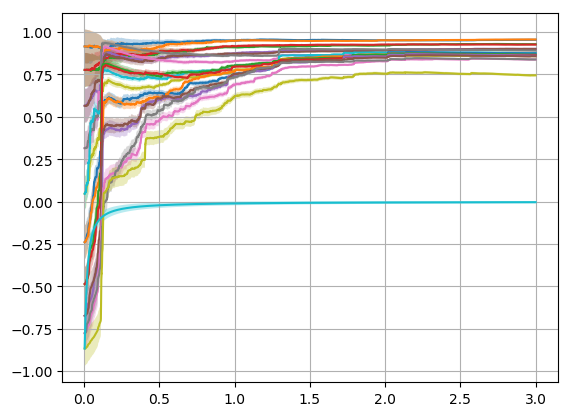

In [26]:
for k = 1:size(μ_θ_mem,2)
    plt.plot(t[bufsize:end], μ_θ_mem[bufsize:end,k])
    plt.fill_between(t[bufsize:end], μ_θ_mem[bufsize:end,k].+sqrt.(Σ_θ_mem[bufsize:end,k]), μ_θ_mem[bufsize:end,k].-sqrt.(Σ_θ_mem[bufsize:end,k]), alpha=0.3)
end
plt.grid()

<source src="data:audio/wav;base64,UklGRvR2AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0Ybh2AQB2Dym9NGgzPR1YnD13eqI9CBBZPW1IvjxK+yy9AfA8vADBI7zh0E+7JrLmPDIT9Dusk509ASwjO1ZhvLy4nbi9f2ZnvZ+G8b1ndd69z4nCvZ28w73S6KI8bn0bvK4U/zwInbo9EiccPdZ0aD183Fc9VTG1PHp/xz2pbAs9dINqPEC1c7v5WK28o1wXO11D4TsLSYK6mt8wvGvtej2XKjE7JDtHPGIpmrvzLEu7T2GVO2JMID0Lhzo9lsRevcTwD7yDTas7qOKDPHF2ljuFrls90N4HvNgVArxvpSS9u7ilvLZ8vrwNd2M9NPm6PAOTwD3osjC9Q6o6OxTgb71G3Ou9/d5ivXzEELtXG5a9QUVovWSwALz8hI49VEgKPTyNXTwpRQu9aeS0vZ17mb1SFL+9xLnOvDh6aL1UBG67R1uqvXKXMrzS09+7AQI7Pc0/oD14g5S8G6Q3PWB7Mj2UYd88kcPRvITO9Lo1Die956puPZir0zxpOlg8f2Q2PrTIzbwJVo899xmjvErjyLx1W0Q8jMKBPSQEoT11nF48IwFNPZcPWj28WoW83I7qu7Mfj7wYmp29pIy+vHzRjr2xKNK8epX3PE7uFz0ZsxI8/cTpvHs9Q72Smg+8RwgdPXwaTT2eqcq8D2SgvCD/xr2xP/K8CgwkvZpsLr3zgzm9k8YqvXVWgL0KG8i9gvqMvWrtAr22KY89IQ6ZPZNvqj3tBPQ9YgiNPVHEDDwIXtK7RLQtvI8bNT1fCwG7LEzXPSJJmb2JQky9mR1suxpQBj1ea6M9XdGPPBYbBb1CmDo9CmD8PBwcZT06MwU9TYAEu2vPu7xa+528EHdQugsd37pCiHq9oCoHvOy5gDvZXn49wfq1vDIldLzNL4K9WBK0vGCRnT2KX4A9lcy5PeLmqz0WrCy7YO1hPQdjZLzg/3a9YxFrvQEjd7vNFD+9vgXpvNjnOr4CJAi+Axz4vP/+C73hdlW9C6xMvNOzhzxEoE+8WPlNvXF9KT2kxz49SH2PvMENjL23I4y9pXi2vQ9cYL1U/zE9vrmRPYBskzzLFd+8+R3bPJXQVbv5rcg663PzPcSEbj0ImqE90CEKPvKMHD538Zg9xFEMO7UkDbxJIXI7Sz6bPcctrz1Yizy98g3RvIWivL0t5dq9v8BCPEP9sb2PaFm8FFXSPDOrN70EnJY94C7+PdsYvz2lyBU+9kTPPQMxmbyaT509OBX5PFdqzbyWWH67i5Asvnu9AL7wzZy9WlW+vXmlZ718F8S9PBzpvFULgzzYA0A8Lc+GvcDMoL1F50o8ppO0vawqxz05rR0+20GgPHabPL0ssr+9KBfjvDqIejxjorG8N7CKvZV1mjyGAnw83pTiu5HJe7tdDJ68RUKbPJul6DzRZxq7wVVDvQzg6D1vWn08Ph//PN+pgb2kq++8ShChPBWE+jsuYhg8+kB7PQ47rzvJlxU85+rmPEL/F72uSCY9P0m/PWswjzztsZu8msLPPAjwnD2lCY09bP2bvfRSHr1GYS+99dF9vRsgZ7z3JgO9l9lrPZJBbTwIpQ69TLY0Pe021j2lZ7s9HlZovU4tur11D/e8CZu2vW5hjb3iIt68CrUpPXYLl70PefS8Jti1vUcJm70pp5S83vk2PeNBpTyCKwS9b4PcOTtHEL3a85m96xkTPZl86j2vpBE+DBXXPbrcoD3S+6o9+h55PU1LFT2PsEg9ZV5ZPaQyyTzEyyA9uVxOPNyZhjwNW603uuECvY1XibyjqoS8BPlCuwuW6ToCrhA9yluQudHhSL1B3BK9c8iyvby8LL7vWUe+AaSQvbDWGzy22cc8GtioO4r/RLzUg4i9U7NEPJfdXj0MpAY98cOoPYHRmbvrFzu9urTJPNOfazxN8xO949UHvfZVFLxROWe8OWr2OwxM8rzoV6W9hHa8vdE3U70q1IC9o1mvvMesLD1N79g8WbapPUQsbj04I8a8Lg2RvRG5E7qQDDW9j7zQO7xX4T1Lbwc+1EYhPYDqiD02XUI8EcxbPYpBuTyvKJ09ARv5PYNRgD2WlbE92uHjPLHedD1sgdy8RW4ou8abKDpwdbq8BHofvRYO1L1llZO96iGBvRCi2zzMF/g9DhmXPdPjgT2y6Cg9IZ4TPToV9rxCvMy8l0jpO5CozL1htQu+D9civgcm0r3NgYm92nOAvDMnlLtaFaa9TqjduL+oLz1XukY8QBTAPOBZJj1UlDg9WMX5PKOavzs/X4M9AY1bPYlE9DzC8xs9XrMYPb8RRD1JYN68LOUzvbAivr01JJS9QLR7va/jAr6kAPG9wGyvvasRybuCO/883+TlPCq9HT2NJJ48MYmHPVPKoD36tL09n0s9PXw+kD1LG688yGvSvTBaWL0Fi8Q8U7F0PP5a6LsjWAs98wgTvLT7LTxehDq92v5wvd8GsTyySoo9gfuDPCYkBD0CLiY9VzJjvWUDsDvfggq8/yuUPIxlRj1R3Em9mwvEPMLkfb06fJW9lhmiu8++gz1avq09ul86vEwHPD0PyHU9SqshvaAbxTuzG1k9NQhdvJx/prxFF448OqKDvCKZjr33WJI7rumfvCyFBr24nQS63fROvZctLbyWqyk9IsmcvX3K7rw3IW49N/QlPkL4vT3vQZy9Ukmnvd7qGLt+Q0E9vfIJvcyEajwXWTu9KumDvbGXxrwrnJG9/gDpveKobb0tQPe8NIjGPeq19D3JNmc9Bbu7PfD4/D3Ebnc9zRoPPVJ+ZjzF7nO9CHbOvXaqGr4vyhG+lMdKvZsaPT1CPgA+1X2+PUby1jv9UM47AEGAu0vVCr1yN049FujDPOME1bv1FOw8yNYsvRV6Lr0KLY+9j9MdPdZAfD3oJPc8EF9kvSvcgr3M+Zk8koehPHEnRT22qY89g59wvdYFzb3q8bG8UGGtvARCb7tFZ8Y8Qpc+Pfx/QT2ueQM+WFyqPeUnez2Euhc9zGPnO39WTzuRjWi8APyOvXYYz7yudtK9cboAvgWmj73m3Cq82tFevZ4yeL11G829PFQuvnsRrL3WWXm9ywo5PVN0cD2ZBFG7WMdUPb6tpD1ciqI8/1ekPUTinD1sjSA9Stc1PcARiT2Oulo8mEaUPLUv7j0S6M48TQy9PEVKIjw+F0e838vnPYBjDzwD/4+83isXPcuN8DwuOYW6buMNPVHYojt659e6tqQ/vYIlib1dH228NiRZvSuRHr25i2C8jDhwvd4jjL2boK66vdIuPKCaxj3CVCg9Cr1UvJBcyDvCHn689tKavfPtrLzpHkA9AMfqPGH3oz3IhRi7BqlWvdubCL2Rgty9gAS/vbkoiL0Ignq9FM6uPHadxrxC8AW9fUo5PTE8ojzJ9KG9XRKrvHbh2Dy1VQw9SeN7PcKo4z2FDKY9YLXxPGXhuD0uQno8sJi+vDAlR7wrf2u90HgbvZz6Ur0HGmY8PxWvPMm3hjsLzwQ9POAtO49JLD3jLAC96vCRvCevkbrTygW9cQvcvPo+v71h7wG91nt0PbSN8LgFqzC9gmVovSGqmL32/WS9PlgoPYB2ILzmW248WH4RPB/UJj3Cm3w8CtqiPc/QiD3oZIk85CazPMX3mL0hOv878QVJvHuVhL2K+9i8GAwDvbF1xz3LDgY+TP14PbAUAD6lJ7o9BoevPeOSqDw5qVQ9TWCKPLienT2e3Xk9xPhqvUeVO7zXrzO+Ve6JPEEHpj1U+Eq97In2vCkjEb4h1NO9QMsxvYidx7yDfSi+g6kFvck0nL18Y6s9rA1fPXLb4r1U8GW8R1R6Okk1Gj3a05Q9W0gVvZAJ27wYieo8tCTSPbb2wD3qHYQ8jDaivTlcv7yqI4495IVrPQwZpT3itLq8FTN2vMi7WTy5m

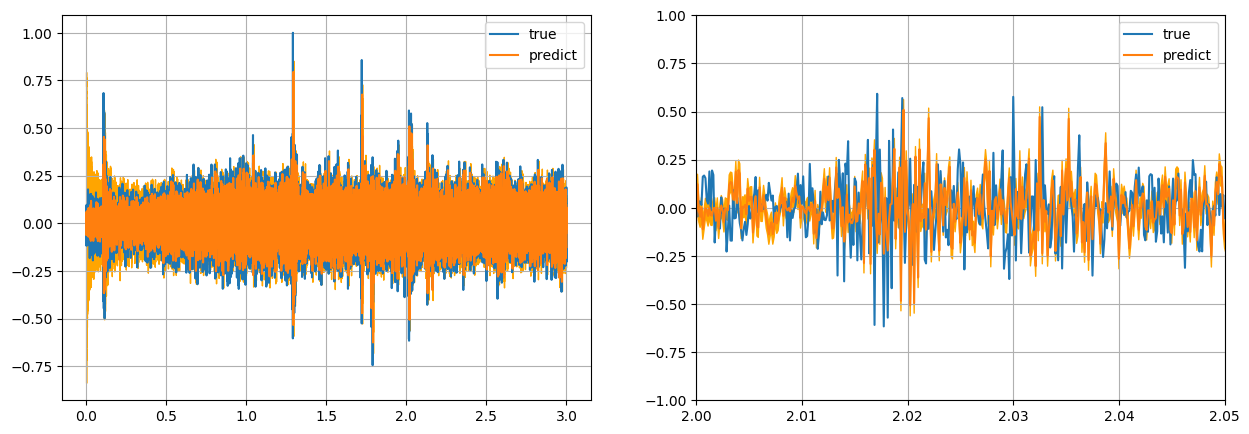

In [27]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[1].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[1].fill_between(t[bufsize:end], μ_x_mem[bufsize:end] .+ sqrt.(Σ_x_mem[bufsize:end]), μ_x_mem[bufsize:end] .- sqrt.(Σ_x_mem[bufsize:end]), color="orange")
ax[1].grid(), ax[1].legend()
ax[2].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[2].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[2].fill_between(t[bufsize:end], μ_x_mem[bufsize:end] .+ sqrt.(Σ_x_mem[bufsize:end]), μ_x_mem[bufsize:end] .- sqrt.(Σ_x_mem[bufsize:end]), color="orange")
ax[2].grid(), ax[2].legend(), ax[2].set_xlim(2,2.05), ax[2].set_ylim(-1,1)
audioplayers(yi[bufsize:end], μ_x_mem[bufsize:end], fs=fs)

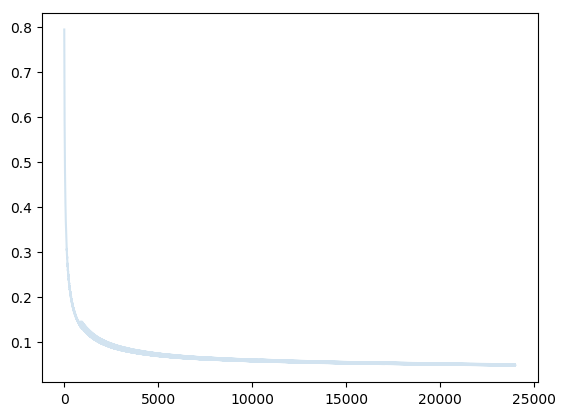

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005D185780>

In [28]:
plt.plot(sqrt.(Σ_x_mem[bufsize:end]), alpha=0.2)

In [38]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 100 # nr of iterations

# get parameters
μ_θi, Σ_θi = ForneyLab.unsafeMean(marginals[:θ]), ForneyLab.unsafeCov(marginals[:θ])
v_wi, nu_wi = marginals[:w].params[:v], marginals[:w].params[:nu]


function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(length(f))
    xif[1] = 0
    for n = 2:N
        θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
        ws = rand(MvNormal(zeros(length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = θs.*sif[:,n-1] + ws
        xif[n] = sif[:,n]'*cos.(2*pi*f/fs*n) 
    end
    return xif
end

function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
    end
    return squeeze(10*log10.(mean(psd, dims=1))), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
end

mean_psd, std_psd = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd = std_psd[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))
plt.plot(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, mean_psd, color="orange")
plt.fill_between(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, mean_psd .- std_psd, mean_psd .+ std_psd, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)

;

DimensionMismatch: DimensionMismatch("The dimensions of mu and Sigma are inconsistent.")

In [30]:
x_true = yi[bufsize:end]
x_μ_pred = μ_x_mem[bufsize:end]
x_σ_pred = sqrt.(abs.(Σ_x_mem[bufsize:end]));

In [31]:
MSE = mean(abs2.(x_true - x_μ_pred))
MAE = mean(abs.(x_true - x_μ_pred))
BME = mean([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])

MSE, MAE, BME

(0.01782091215682697, 0.10309251343652531, -0.9308564024775455)

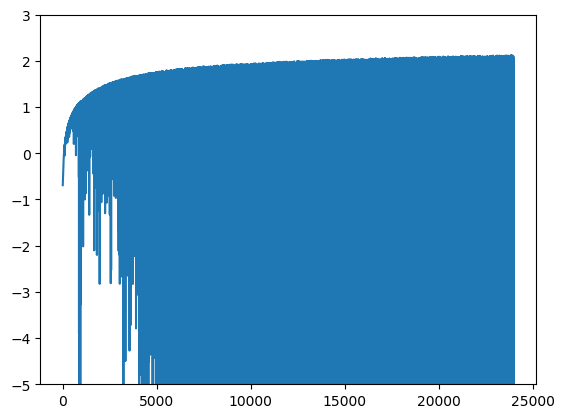

(-5, 3)

In [32]:
plt.plot([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])
plt.ylim(-5,3)